# 🚀 CatBoost Training & Threshold Tuning

**Purpose:** Train a CatBoost model and learn how to tune the classification threshold to achieve target recall.

> This notebook shows:
> - How to train CatBoost for churn prediction
> - How changing the threshold affects Precision vs Recall
> - How to find the optimal threshold for your business goal

## 📦 What You'll Learn
- Load prepared data from the previous notebook
- Train a CatBoost classifier
- Understand the **Precision-Recall tradeoff**
- Tune the threshold to achieve target recall (e.g., 80%)
- Save the trained model for deployment

## 🧰 Prerequisites
- Python 3.9+
- Packages: `pandas`, `numpy`, `catboost`, `scikit-learn`, `matplotlib`

```bash
# Install if needed:
pip install pandas numpy catboost scikit-learn matplotlib
```

## ♻️ Reproducibility & Environment Capture
- **Fixed seeds** for determinism
- Save **package versions** and run metadata
- Unique **artifact run folder**


In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, UTC

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Create artifact directory
RUN_TS = datetime.now(UTC).strftime("%Y%m%dT%H%M%SZ")
ARTIFACT_DIR = f"artifacts/model_training_{RUN_TS}"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

print(f"Seed: {SEED} | Artifacts: {ARTIFACT_DIR}")

Seed: 42 | Artifacts: artifacts/model_training_20251016T185541Z


In [2]:
# Import required libraries
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt

print("Libraries imported successfully")

Libraries imported successfully


## ⚙️ Configuration
Edit **only here** to switch sources and behavior.


In [3]:
# Configuration
CONFIG = {
    # Data paths
    "train_data": "artifacts/run_*/train.parquet",
    "val_data": "artifacts/run_*/val.parquet",
    
    # Target
    "target_col": "churn",
    
    # ID features to drop
    "id_features": ["idconsumo", "codigocontaservico", "idconta", "iddim_cliente", 
                   "idcliente", "codigocliente", "iddim_conta", "codigoconta"],
    
    # Model hyperparameters
    "iterations": 500,
    "learning_rate": 0.08,
    "depth": 6,
    "l2_leaf_reg": 5.0,
    "random_seed": SEED,
    
    # Target recall for threshold tuning
    "target_recall": 0.80
}

print(f"✓ Config loaded | Target recall: {CONFIG['target_recall']:.0%}")

✓ Config loaded | Target recall: 80%


## 📥 Load Data
Load data generated from data_preparation_example.ipynb

In [4]:
import glob

# Find the latest data from previous notebook
train_files = sorted(glob.glob("artifacts/run_*/train.parquet"))
val_files = sorted(glob.glob("artifacts/run_*/val.parquet"))

# Load most recent data
train_df = pd.read_parquet(train_files[-1])
val_df = pd.read_parquet(val_files[-1])

print(f"Train: {train_df.shape} | Churn rate: {train_df['churn'].mean():.1%}")
print(f"Val:   {val_df.shape} | Churn rate: {val_df['churn'].mean():.1%}")

Train: (80000, 58) | Churn rate: 34.5%
Val:   (10000, 58) | Churn rate: 11.6%


## 🔎 Quick Profile

In [5]:
# Quick data overview
print(f"Features: {train_df.shape[1] - 1}")
print(f"Samples: {len(train_df):,} train, {len(val_df):,} val")

# Count feature types
n_numeric = len(train_df.select_dtypes(include=[np.number]).columns) - 1  # exclude target
n_categorical = len(train_df.select_dtypes(include=['object']).columns)

print(f"Feature types: {n_numeric} numeric, {n_categorical} categorical")

Features: 57
Samples: 80,000 train, 10,000 val
Feature types: 44 numeric, 10 categorical


## 🔧 Prepare Data for CatBoost
CatBoost can handle categorical features natively - we just need to identify them

In [6]:
from catboost import Pool

# Drop ID features
id_cols = [col for col in CONFIG['id_features'] if col in train_df.columns]
train_df = train_df.drop(columns=id_cols)
val_df = val_df.drop(columns=id_cols)

# Separate features and target
X_train = train_df.drop(columns=['churn'])
y_train = train_df['churn'].values
X_val = val_df.drop(columns=['churn'])
y_val = val_df['churn'].values

# Drop datetime columns (CatBoost can't handle them)
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns.tolist()
X_train = X_train.drop(columns=datetime_cols)
X_val = X_val.drop(columns=datetime_cols)

# Find categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cat_indices = [X_train.columns.get_loc(col) for col in cat_features]

# Fill missing values in categorical columns
for col in cat_features:
    X_train[col] = X_train[col].fillna('<MISSING>')
    X_val[col] = X_val[col].fillna('<MISSING>')

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_indices)

print(f"✓ Ready: {X_train.shape[1]} features ({len(cat_features)} categorical)")

✓ Ready: 46 features (9 categorical)


## 🤖 Train CatBoost Model
Using hyperparameters from production config

In [7]:
from catboost import CatBoostClassifier

# Create model
catboost_model = CatBoostClassifier(
    iterations=CONFIG['iterations'],
    learning_rate=CONFIG['learning_rate'],
    depth=CONFIG['depth'],
    l2_leaf_reg=CONFIG['l2_leaf_reg'],
    random_seed=CONFIG['random_seed'],
    verbose=100,
    loss_function='Logloss',
    eval_metric='PRAUC'
)

print("Training CatBoost...\n")

# Train with early stopping
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=50
)

print(f"\n✓ Training complete! Best iteration: {catboost_model.get_best_iteration()}")

# Get predictions
y_val_proba_cb = catboost_model.predict_proba(val_pool)[:, 1]

# Calculate metrics
roc_auc_cb = roc_auc_score(y_val, y_val_proba_cb)
pr_auc_cb = average_precision_score(y_val, y_val_proba_cb)

# Find threshold for target recall (80%)
precisions_cb, recalls_cb, thresholds_cb = precision_recall_curve(y_val, y_val_proba_cb)
idx = np.where(recalls_cb[:-1] >= CONFIG['target_recall'])[0][-1]
best_threshold_cb = thresholds_cb[idx]
best_recall_cb = recalls_cb[idx]
best_precision_cb = precisions_cb[idx]
best_f1_cb = 2 * best_precision_cb * best_recall_cb / (best_precision_cb + best_recall_cb)

print(f"\n📊 CatBoost @ {CONFIG['target_recall']:.0%} recall:")
print(f"  ROC-AUC: {roc_auc_cb:.3f}")
print(f"  Threshold: {best_threshold_cb:.3f}")
print(f"  Precision: {best_precision_cb:.3f}")
print(f"  F1: {best_f1_cb:.3f}")

Training CatBoost...

0:	learn: 0.5502944	test: 0.2393833	best: 0.2393833 (0)	total: 114ms	remaining: 56.6s
100:	learn: 0.6280218	test: 0.2943208	best: 0.2943524 (78)	total: 4.96s	remaining: 19.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2958524368
bestIteration = 129

Shrink model to first 130 iterations.

✓ Training complete! Best iteration: 129

📊 CatBoost @ 80% recall:
  ROC-AUC: 0.766
  Threshold: 0.251
  Precision: 0.204
  F1: 0.325


## 🆚 Compare with XGBoost

Let's train an XGBoost model and compare it with CatBoost.

**Note:** Modern XGBoost (v1.6+) can handle categorical features natively, just like CatBoost!

In [8]:
import xgboost as xgb

# Prepare data for XGBoost - convert categorical to 'category' dtype
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()

for col in cat_features:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_val_xgb[col] = X_val_xgb[col].astype('category')

print("Training XGBoost with native categorical support...\n")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=CONFIG['iterations'],
    learning_rate=CONFIG['learning_rate'],
    max_depth=CONFIG['depth'],
    reg_lambda=CONFIG['l2_leaf_reg'],
    random_state=CONFIG['random_seed'],
    eval_metric='aucpr',
    early_stopping_rounds=50,
    enable_categorical=True
)

xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_val_xgb, y_val)],
    verbose=100
)

print("\n✓ Training complete!")

# Get predictions
y_val_proba_xgb = xgb_model.predict_proba(X_val_xgb)[:, 1]

# Calculate metrics
roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
pr_auc_xgb = average_precision_score(y_val, y_val_proba_xgb)

# Find threshold for target recall (80%)
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_val, y_val_proba_xgb)
idx = np.where(recalls_xgb[:-1] >= CONFIG['target_recall'])[0][-1]
best_threshold_xgb = thresholds_xgb[idx]
best_recall_xgb = recalls_xgb[idx]
best_precision_xgb = precisions_xgb[idx]
best_f1_xgb = 2 * best_precision_xgb * best_recall_xgb / (best_precision_xgb + best_recall_xgb)

print(f"\n📊 XGBoost @ {CONFIG['target_recall']:.0%} recall:")
print(f"  ROC-AUC: {roc_auc_xgb:.3f}")
print(f"  Threshold: {best_threshold_xgb:.3f}")
print(f"  Precision: {best_precision_xgb:.3f}")
print(f"  F1: {best_f1_xgb:.3f}")

Training XGBoost with native categorical support...

[0]	validation_0-aucpr:0.25124
[66]	validation_0-aucpr:0.26172

✓ Training complete!

📊 XGBoost @ 80% recall:
  ROC-AUC: 0.754
  Threshold: 0.305
  Precision: 0.197
  F1: 0.316


## 🏅 Select Best Model & Export Artifacts

   Model  ROC-AUC   PR-AUC  Precision  Recall       F1  Threshold
CatBoost 0.766017 0.296448   0.204091     0.8 0.325215   0.250576
 XGBoost 0.754298 0.278633   0.196527     0.8 0.315539   0.304918

🏆 Winner: CatBoost


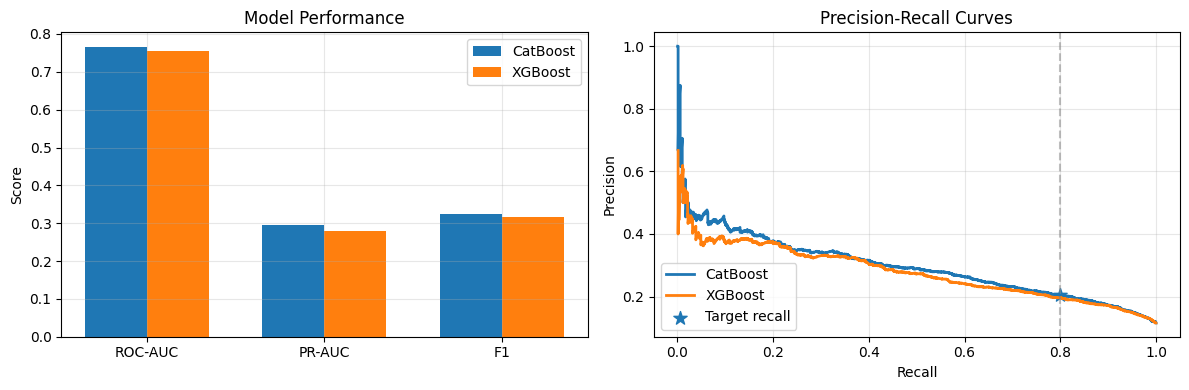


✅ Selected CatBoost for deployment


In [9]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['CatBoost', 'XGBoost'],
    'ROC-AUC': [roc_auc_cb, roc_auc_xgb],
    'PR-AUC': [pr_auc_cb, pr_auc_xgb],
    'Precision': [best_precision_cb, best_precision_xgb],
    'Recall': [best_recall_cb, best_recall_xgb],
    'F1': [best_f1_cb, best_f1_xgb],
    'Threshold': [best_threshold_cb, best_threshold_xgb]
})

print(comparison.to_string(index=False))

# Select winner based on ROC-AUC
winner = "CatBoost" if roc_auc_cb >= roc_auc_xgb else "XGBoost"
print(f"\n🏆 Winner: {winner}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
metrics = ['ROC-AUC', 'PR-AUC', 'F1']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, [roc_auc_cb, pr_auc_cb, best_f1_cb], width, label='CatBoost')
axes[0].bar(x + width/2, [roc_auc_xgb, pr_auc_xgb, best_f1_xgb], width, label='XGBoost')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall curves
axes[1].plot(recalls_cb[:-1], precisions_cb[:-1], label='CatBoost', linewidth=2)
axes[1].plot(recalls_xgb[:-1], precisions_xgb[:-1], label='XGBoost', linewidth=2)
axes[1].scatter([best_recall_cb], [best_precision_cb], s=100, marker='*', label='Target recall')
axes[1].axvline(CONFIG['target_recall'], color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model for saving
if winner == "CatBoost":
    best_model = catboost_model
    best_threshold = best_threshold_cb
else:
    best_model = xgb_model
    best_threshold = best_threshold_xgb

print(f"\n✅ Selected {winner} for deployment")

## 💾 Save Best Model & Artifacts

In [10]:
import pickle

# Save the winning model
model_path = os.path.join(ARTIFACT_DIR, "model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✓ Model saved: {model_path}")

# Save feature importance
if winner == "CatBoost":
    importance = best_model.get_feature_importance()
else:
    importance = best_model.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

# Save to file
fi_path = os.path.join(ARTIFACT_DIR, "feature_importance.csv")
feature_importance.to_csv(fi_path, index=False)
print(f"\n✓ Feature importance saved: {fi_path}")

✓ Model saved: artifacts/model_training_20251016T185541Z/model.pkl

Top 10 most important features:
              feature  importance
          past_churns   19.287278
  tipo_produto_actual   17.254043
      contract_number    8.829119
    topup_total_value    8.462627
gap_since_prev_expiry    8.158171
     n_prev_contracts    7.761852
    contract_len_days    7.315990
    n_dias_subscricao    4.338540
       topup_cv_value    2.933649
          tenure_days    1.782685

✓ Feature importance saved: artifacts/model_training_20251016T185541Z/feature_importance.csv


## 🔬 Bonus: Check for Overfitting

Let's check if the best model generalizes well

In [11]:
# Check for overfitting by comparing train vs validation performance
print(f"Overfitting check for {winner}:\n")

# Get predictions on training set
if winner == "CatBoost":
    y_train_proba = best_model.predict_proba(train_pool)[:, 1]
else:
    y_train_proba = best_model.predict_proba(X_train_xgb)[:, 1]

# Calculate train metrics
train_roc = roc_auc_score(y_train, y_train_proba)
y_train_pred = (y_train_proba >= best_threshold).astype(int)
train_f1 = f1_score(y_train, y_train_pred)

# Compare with validation
val_roc = roc_auc_cb if winner == "CatBoost" else roc_auc_xgb
val_f1 = best_f1_cb if winner == "CatBoost" else best_f1_xgb

print(f"ROC-AUC: Train={train_roc:.3f}, Val={val_roc:.3f}, Diff={train_roc-val_roc:.3f}")
print(f"F1:      Train={train_f1:.3f}, Val={val_f1:.3f}, Diff={train_f1-val_f1:.3f}")

# Interpretation
if train_roc - val_roc > 0.05:
    print("\n⚠️ Warning: Model may be overfitting (train >> val)")
else:
    print("\n✓ Model generalizes well")

Overfitting check for CatBoost:

ROC-AUC: Train=0.775, Val=0.766, Diff=0.009
F1:      Train=0.616, Val=0.325, Diff=0.291

✓ Model generalizes well


In [ ]:
# Optional: Log to MLflow (set to True to enable)
USE_MLFLOW = False

if USE_MLFLOW:
    import mlflow
    
    mlflow.set_experiment("churn-model-comparison")
    
    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_params({
            'iterations': CONFIG['iterations'],
            'learning_rate': CONFIG['learning_rate'],
            'depth': CONFIG['depth'],
            'model': winner
        })
        
        # Log metrics
        mlflow.log_metric('roc_auc', val_roc)
        mlflow.log_metric('f1', val_f1)
        mlflow.log_metric('threshold', best_threshold)
        
        # Log model
        mlflow.sklearn.log_model(best_model, "model")
        
        print("✓ Logged to MLflow")
else:
    print("MLflow logging disabled")

MLflow logging disabled
